# Dogs vs Cats
- Kaggle Dataset의 전부를 이용한 개, 고양이 구분
- Dog Image: 12,500개, Cat Image: 12,500개, 총 25,000개
- 출처: pontoregende GitHub

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp drive/MyDrive/Colab\ Notebooks/train.zip .

In [3]:
!unzip -qq train.zip -d dogs-vs-cats

In [4]:
!pwd

/content


In [5]:
!ls -l dogs-vs-cats/

total 732
drwxr-xr-x 2 root root 745472 Sep 20  2013 train


In [6]:
import numpy as np
from glob import glob
import cv2, os, random
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [8]:
# seed 값 설정
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [9]:
path='dogs-vs-cats/train'

In [10]:
## used for resize and in our model
ROW, COL = 96, 96

dogs, cats = [], []
y_dogs, y_cats = [], []

In [11]:
## Definition to load all our dog images
def load_dogs():
    print('Loading all dog images\n')
    dog_path = os.path.join(path, 'dog*')
    for dog_img in glob(dog_path):
        dog = cv2.imread(dog_img)
        dog = cv2.cvtColor(dog, cv2.COLOR_BGR2GRAY)
        dog = cv2.resize(dog, (ROW, COL))
        dog = image.img_to_array(dog)
        dogs.append(dog)
    print('All dog images loaded')

In [12]:
## Definition to load all our cat images
def load_cats():
    print('Loading all cat images\n')
    cat_path = os.path.join(path, 'cat*')
    for cat_img in glob(cat_path):
        cat = cv2.imread(cat_img)
        cat = cv2.cvtColor(cat, cv2.COLOR_BGR2GRAY)
        cat = cv2.resize(cat, (ROW, COL))
        cat = image.img_to_array(cat)
        cats.append(cat)
    print('All cat images loaded')

In [13]:
## in case we want to see if our images was saved correctly in arrays we can use those codes
def show_dogs():
    plt.figure(figsize=(12,4))    
    for i in range(5):
        plt.subplot(1, 5, i+1)
        img = image.array_to_img(random.choice(dogs))
        plt.imshow(img, cmap=plt.get_cmap('gray'))
        
        plt.axis('off')
        plt.title(f'Supposed to be a {classes[0]}')        
    plt.show()

In [14]:
def show_cats():
    plt.figure(figsize=(12,4))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        img = image.array_to_img(random.choice(cats))
        plt.imshow(img, cmap=plt.get_cmap('gray'))

        plt.axis('off')
        plt.title(f'Supposed to be a {classes[1]}')
    plt.show()

In [15]:
load_dogs()

Loading all dog images

All dog images loaded


In [16]:
load_cats()

Loading all cat images

All cat images loaded


In [17]:
classes = ['dog', 'cat']

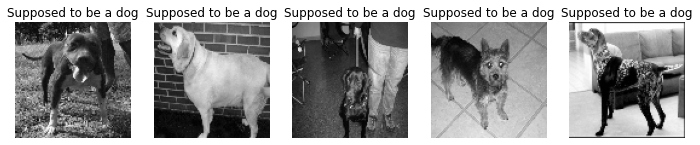

In [18]:
show_dogs()

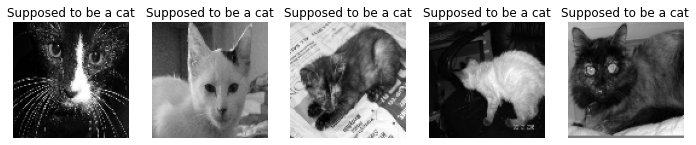

In [19]:
show_cats()

In [20]:
## just change the labels for 0 and 1
y_dogs = [1 for item in enumerate(dogs)]
y_cats = [0 for item in enumerate(cats)]

In [21]:
## converting everything to Numpy array to fit in our model
## them creating a X and target file like we used to see
## in Machine and Deep Learning models
dogs = np.asarray(dogs).astype('float32') / 255
cats = np.asarray(cats).astype('float32') / 255
y_dogs = np.asarray(y_dogs).astype('int32')
y_cats = np.asarray(y_cats).astype('int32')

In [22]:
X = np.concatenate((dogs, cats), axis=0)
y = np.concatenate((y_dogs, y_cats), axis=0)

In [23]:
X.shape, y.shape

((25000, 96, 96, 1), (25000,))

In [24]:
IMG_CHANNEL = 1
BATCH_SIZE = 128
N_EPOCH = 30
VERBOSE = 2
VALIDAION_SPLIT = 0.2
OPTIM = Adam()
N_CLASSES = len(classes)

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=seed
)

In [26]:
## One-Hot Encoding
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, N_CLASSES)
y_test = to_categorical(y_test, N_CLASSES)

In [27]:
## Here is our model as a CNN
model = Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=(ROW, COL, IMG_CHANNEL), activation='relu'),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(.25),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(.5),
    Dense(N_CLASSES, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0

In [28]:
model.compile(loss='categorical_crossentropy', 
              optimizer=OPTIM, metrics=['accuracy'])

In [29]:
## to save checkpoint to use latter
modelpath = 'model/dogs_vs_cats_redux_checkpoint.h5'
checkpoint = ModelCheckpoint(filepath=modelpath, save_best_only=True, verbose=1)

In [30]:
history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, epochs=N_EPOCH, 
                    validation_split=VALIDAION_SPLIT,
                    verbose=VERBOSE, callbacks=[checkpoint])

Epoch 1/30
125/125 - 42s - loss: 0.6836 - accuracy: 0.5663 - val_loss: 0.6619 - val_accuracy: 0.5865

Epoch 00001: val_loss improved from inf to 0.66192, saving model to model/dogs_vs_cats_redux_checkpoint.h5
Epoch 2/30
125/125 - 9s - loss: 0.5903 - accuracy: 0.6863 - val_loss: 0.5625 - val_accuracy: 0.7067

Epoch 00002: val_loss improved from 0.66192 to 0.56252, saving model to model/dogs_vs_cats_redux_checkpoint.h5
Epoch 3/30
125/125 - 9s - loss: 0.5389 - accuracy: 0.7246 - val_loss: 0.5327 - val_accuracy: 0.7203

Epoch 00003: val_loss improved from 0.56252 to 0.53266, saving model to model/dogs_vs_cats_redux_checkpoint.h5
Epoch 4/30
125/125 - 9s - loss: 0.4951 - accuracy: 0.7628 - val_loss: 0.4748 - val_accuracy: 0.7713

Epoch 00004: val_loss improved from 0.53266 to 0.47484, saving model to model/dogs_vs_cats_redux_checkpoint.h5
Epoch 5/30
125/125 - 9s - loss: 0.4578 - accuracy: 0.7826 - val_loss: 0.4668 - val_accuracy: 0.7707

Epoch 00005: val_loss improved from 0.47484 to 0.46676

In [31]:
acc = model.evaluate(X_test, y_test, verbose=2)[1]
print('MODEL ACCURACY: %.5f' % acc)

157/157 - 1s - loss: 0.9006 - accuracy: 0.8286
MODEL ACCURACY: 0.82860


In [32]:
from tensorflow.keras.models import load_model
best_model = load_model(modelpath)
acc = best_model.evaluate(X_test, y_test, verbose=2)[1]
print('Best model accuracy: %.5f' % acc)

157/157 - 1s - loss: 0.4156 - accuracy: 0.8124
Best model accuracy: 0.81240


In [33]:
# 검증셋
y_vloss = history.history['val_loss']
y_vacc = history.history['val_accuracy']

# 학습셋
y_loss = history.history['loss']
y_acc = history.history['accuracy']

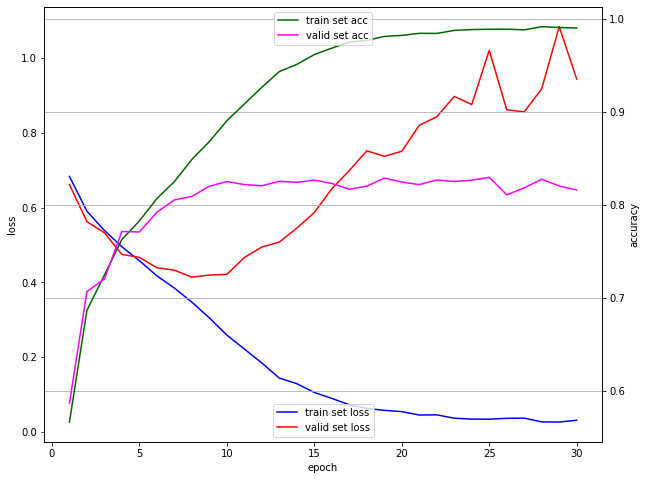

In [34]:
x_len = np.arange(1, len(y_loss)+1)
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c="blue", label='train set loss')
ax0.plot(x_len, y_vloss, c="red", label='valid set loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c="darkgreen", label='train set acc')
ax1.plot(x_len, y_vacc, c="magenta", label='valid set acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='lower center')
ax1.legend(loc='upper center')
plt.grid()
plt.show()